In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/aneesh10/cricket-shot-dataset'


od.download(dataset_url)


data_dir = './cricket-shot-dataset/data'
import os

os.listdir(data_dir)

dataset = ImageFolder(data_dir)

import torchvision.transforms as tt
normalize = tt.Normalize(
        mean=[0.8482, 0.8485, 0.7730],
        std=[9.1425, 9.1720, 8.4957],
)


dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

from torch.utils.data import DataLoader

batch_size = 32
# 16 - 90
# 32 - 92

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

num_classes = 4
num_epochs = 40
batch_size = 16
learning_rate = 0.005
in_channels = 3
model = ResNet9(3,4).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_dl)

total_step = len(train_dl)

accuracies = []
losses=[]

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    losses.append(loss.item())
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
        accuracies.append(100*correct/total)





/home/zoro/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Skipping, found downloaded files in "./cricket-shot-dataset" (use force=True to force download)
Epoch [1/40], Step [133/133], Loss: 3.1943
Accuracy of the network on the 5000 validation images: 28.8135593220339 %


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 373, in _send
    n = write(self._h

KeyboardInterrupt: 

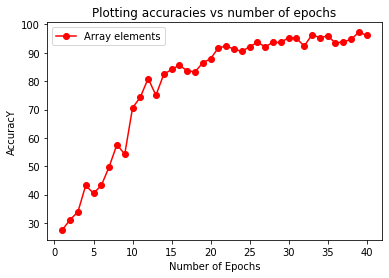

In [69]:
import numpy as np
import matplotlib.pyplot as plt
 
x = np.array(range(1, len(accuracies)+1))
y = np.array(accuracies)
plt.title("Plotting accuracies vs number of epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("AccuracY")
plt.plot(x, y, color = "red", marker = "o", label = "Array elements")
plt.legend()
plt.show()


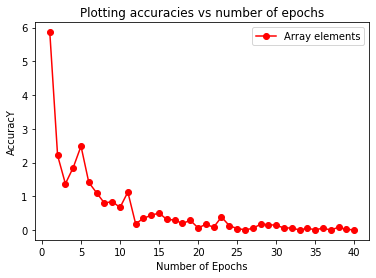

In [70]:
import numpy as np
import matplotlib.pyplot as plt
 
x = np.array(range(1, len(losses)+1))
y = np.array(losses)
plt.title("Plotting accuracies vs number of epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("AccuracY")
plt.plot(x, y, color = "red", marker = "o", label = "Array elements")
plt.legend()
plt.show()


In [72]:
from tqdm import tqdm
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(train_dl):
    
    psum = inputs[0].sum(axis=[0,2,3])
    psum_sq += (inputs[0] ** 2).sum(axis = [0, 2, 3])

  0%|          | 0/133 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 133/133 [00:19<00:00,  7.00it/s]


In [71]:
count = batch_size*64*64
print(psum,psum_sq)
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)
print(total_mean,total_std)

tensor([55586.7773, 55607.7109, 50658.7578]) tensor([5524949.0000, 5560493.0000, 4769388.5000])
tensor([0.8482, 0.8485, 0.7730]) tensor([9.1425, 9.1720, 8.4957])
